<left><img width=25% src="img/cornell_tech2.svg"></left>

# Lecture 22: Tools for Diagnosing Model Performance

### Applied Machine Learning

__Volodymyr Kuleshov__<br>Cornell Tech

# Practical Considerations When Applying Machine Learning

Suppose you trained an image classifier with 80% accuracy. What's next?

* Add more data?
* Train the algorithm for longer?
* Use a bigger model?
* Add regularization?
* Add new features?

We will next learn how to prioritize these decisions when applying ML.

# Part 1: Learning Curves

Learning curves are a common and useful tool for performing bias/variance analysis in a deeper way.

This section is mostly based on [materials](https://www.deeplearning.ai/machine-learning-yearning/) from an e-book by Andrew Ng.

# Review: Overfitting (Variance)

Overfitting is one of the most common failure modes of machine learning.
* A very expressive model (a high degree polynomial) fits the training dataset perfectly.
* The model also makes wildly incorrect prediction outside this dataset, and doesn't generalize.

Models that overfit are said to be __high variance__.

# Review: Underfitting (Bias)

Underfitting is another common problem in machine learning.
* The model is too simple to fit the data well (e.g., approximating a high degree polynomial with linear regression).
* As a result, the model is not accurate on training data and is not accurate on new data.

Because the model cannot fit the data, we say it's __high bias__.

# Learning Curves

Learning curves show performance as a function of __training set size__.
<center><img width=60% src="img/learning_curve1.png"></center>

Learning curves are defined for __fixed hyperparameters__. Observe that dev set error decreases as we give the model more data.

# Visualizing Ideal Performance

It is often very useful to have a target upper bound on performance (e.g., human accuracy); it can also be visualized on the learning curve.
<center><img width=60% src="img/learning_curve2.png"></center>
Extrapolating the red curve suggests how much additional data we need.

In the example below, the dev error has plateaued and we know that adding more data will not be useful.
<center><img width=80% src="img/learning_curve3.png"></center>

# Learning Curves for the Training Set

We can further augment this plot with training set performance.
<center><img width=70% src="img/learning_curve4.png"></center>
The blue curve shows training error as a function of training set size.

A few observations can be made here:
* Training error is normally less that dev set error: the training set is easier to fit.
* Training error *increases* with training set size because our model overfits small datasets.

# Diagnosing High Bias

Learning curves can reveal when we have a bias problem.
<center><img width=60% src="img/learning_curve5.png"></center>
Here, the model can't fit larger datasets, hence it's underfitting.

In practice, in can be hard to visually assess if the dev error has plateaued. Adding the training error makes this easier.
<center><img width=60% src="img/learning_curve6.png"></center>
Here, adding data can no longer help: the blue error can only increase and thus dev error cannot decrease.

# Relationship to Bias/Variance Analysis

Bias/variance analysis correspond to looking at the very last point on the learning curves.
<center><img width=60% src="img/learning_curve6.png"></center>
Looking at the entire curve ensures a more reliable diagnosis.

# Diagnosing High Variance

The following plot shows we have high variance.
<center><img width=70% src="img/learning_curve7.png"></center>
Training error is small (near optimal), but dev set error is large. We can address this by adding more data.

In this plot, we have both high variance and high bias.
<center><img width=70% src="img/learning_curve8.png"></center>
The training error significantly exceeds desired performance, and the dev set error is even higher.

# Practical Considerations

In practice, the following tricks are useful.
* When data is small, performance estimates are noisy, and curves are non-smooth.
* The solution is to average over multiple models trained on random subsets of $m$ points, for each $m$.
* If classes are imbalanced, choose metrics that account for this.

# Learning Curves: An Example

To further illustrate the idea of learning curves, consider the following example.

We will use the `sklearn` digits dataset, a downscaled version of MNIST.

In [16]:
# Example from https://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html
from sklearn.datasets import load_digits
X, y = load_digits(return_X_y=True)

We can visualize these digits as follows:

<Figure size 576x1152 with 0 Axes>

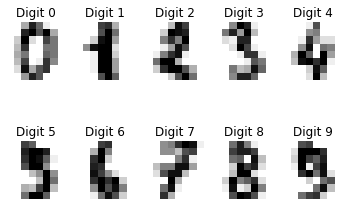

In [17]:
from matplotlib import pyplot as plt

plt.figure(figsize=(8,16))
_, axes = plt.subplots(2, 5)
images_and_labels = list(zip(digits.images, digits.target))
for ax, (image, label) in zip(axes.flatten(), images_and_labels[:10]):
    ax.set_axis_off()
    ax.imshow(image, cmap=plt.cm.gray_r, interpolation='nearest')
    ax.set_title('Digit %i' % label)

This is boilerplate code for visualizing learning curves and it's not essential to understand this example.

In [30]:
import numpy as np
from sklearn.model_selection import learning_curve

def plot_learning_curve(estimator, title, X, y, axes=None, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    """Generate learning curves for an algorithm."""
    if axes is None:
        _, axes = plt.subplots(1, 3, figsize=(20, 5))

    axes[0].set_title(title)
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = \
        learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs,
                       train_sizes=train_sizes,
                       return_times=True)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axes[0].grid()
    axes[0].fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    axes[0].fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
    axes[0].plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training Accuracy")
    axes[0].plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Dev Set Accuracy")
    axes[0].legend(loc="best")

    return plt

We visualize learning curves for two algorithms:
* Gaussian Naive Bayes model, a version of Naive Bayes for continuous inputs $x$
* A support vector machine with a radial basis function (RBF) kernel

<module 'matplotlib.pyplot' from '/Users/kuleshov/work/env/aml/lib/python3.6/site-packages/matplotlib/pyplot.py'>

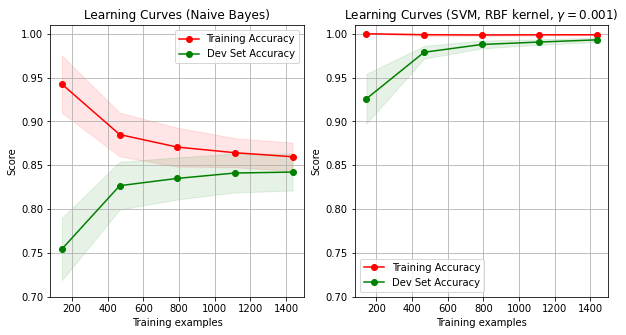

In [31]:
from sklearn.model_selection import ShuffleSplit
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# This is a technical detail, but we will obtain dev set performance via
# cross-valation rather that via a dev set.
# Cross validation is a technique that emulates a separate dev set with small data.
# We also use 100 iterations to get smoother mean test and train curves,
# each time with 20% data randomly selected as a validation set.
cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=0)

title = "Learning Curves (Naive Bayes)"
plot_learning_curve(GaussianNB(), title, X, y, axes=[axes[0]], ylim=(0.7, 1.01), cv=cv, n_jobs=4)

cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
title = r"Learning Curves (SVM, RBF kernel, $\gamma=0.001$)"
plot_learning_curve(SVC(gamma=0.001), title, X, y, axes=[axes[1]], ylim=(0.7, 1.01),cv=cv, n_jobs=4)

We can draw a few takeways:
* The Gaussian model is very simple for this task: performance saturates after ~1,400 examples.
* The SVM is much more expressive: it keeps improving in dev set performance as we give it more data.

# Limitations of Learning Curves

The main limitations of learning curves include:
1. Computational time needed to learn the curves.
2. Learning curves can be noisy and require human intuition to read.

<left><img width=25% src="img/cornell_tech2.svg"></left>

# Part 2: Loss Curves

Another way to understand the performance of the model is to visualize its objective as we train the model.

This section is based on [materials](https://cs231n.github.io/neural-networks-3/) by Andrej Karpathy.

# Review: Model Development Workflow

The machine learning development workflow has three steps:
1. __Training:__ Try a new model and fit it on the training set.

2. __Model Selection__: Estimate performance on the development set using metrics. Based on results, try a new model idea in step #1.

3. __Evaluation__: Finally, estimate real-world performance on test set.

# Loss Curves

Many algorithms minimize a loss function using an iterative optimization procedure like gradient descent.

Loss curves plot the __training objective__ as a function of the number of __training steps__ on training or development datasets.

# Diagnosing Bias and Variance

Loss curves provide another way to diagnose bias and variance.
<center><img width=60% src="img/loss_curve1.png"></center>

A few observations can be made here:
* As we train the model for more epochs, training accuracy improves.
* When we are *not overfitting* (green), validation accuracy tracks training accuracy.

* When we *overfit* (blue), validation and training accuracies have a large gap, and validation accuracy eventually even decreases.

# Overtraining

A failure mode of some machine learning algorithms is *overtraining*.
<center><img width=50% src="img/loss_curve3.png"></center>
Model performance worsens after some number of training steps. The solution is to train for less or preferrably to regularize the model.

A closely related problem is __undertraining__: not training the model for long enough.

This can be diagnosed via a learning curve that shows that dev set performance is still on an improving trajectory.

# Diagnosing Optimization Issues

Loss curves also enable diagnosing optimization problems.
<center><img width=50% src="img/loss_curve2.png"></center>
Here, we show training set accuracy for different learning rates.

Each line is a loss curve with a different learning rate (LR).
* The blue training is still decreasing at the end: the LR is too low.
* The green line plateaus too soon and too high indicating a high LR.
* The yellow curve explodes: the LR was soo high that parameters took a step into a very bad direction.

The red loss curve is not too fast and not too slow.

# Pros and Cons of Loss Curves

Advantages of using loss curves include the following.
1. Producing loss curves doesn't require extra computation.
2. Loss curves can detect optimization problems and overtraining.

Loss curves don't diagnose the utility of adding more data; when bias/variance diagnosis is ambiguous, use learning curves.

<left><img width=25% src="img/cornell_tech2.svg"></left>

# Part 3: Validation Curves

Validation curves help us understand the effects of different hyper-parameters.

# Review: Model Development Workflow

The machine learning development workflow has three steps:
1. __Training:__ Try a new model and fit it on the training set.

2. __Model Selection__: Estimate performance on the development set using metrics. Based on results, try a new model idea in step #1.

3. __Evaluation__: Finally, estimate real-world performance on test set.

# Validation Curves

ML models normally have hyper-parameters, e.g. L2 regularization strength, neural net layer size, number of K-Means clusters, etc.

Loss curves plot __model peformance__ as a function of __hyper-parameter values__ on training or development datasets.

# Validation Curve: An Example

Consider the following example, in which we train a Ridge model on the digits dataset.

Recall the digits dataset introduced earlier in this lecture.

<Figure size 576x1152 with 0 Axes>

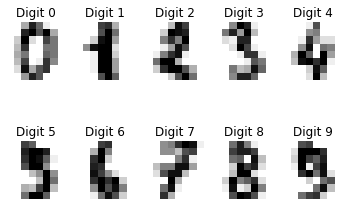

In [3]:
from matplotlib import pyplot as plt

plt.figure(figsize=(8,16))
_, axes = plt.subplots(2, 5)
images_and_labels = list(zip(digits.images, digits.target))
for ax, (image, label) in zip(axes.flatten(), images_and_labels[:10]):
    ax.set_axis_off()
    ax.imshow(image, cmap=plt.cm.gray_r, interpolation='nearest')
    ax.set_title('Digit %i' % label)

We can train an SVM with and RBF kernel for different values of bandwidth $\gamma$ using the `validation_curve` function.

In [32]:
from sklearn.model_selection import validation_curve

# https://scikit-learn.org/stable/auto_examples/model_selection/plot_validation_curve.html
param_range = np.logspace(-6, -1, 5)
train_scores, test_scores = validation_curve(
    SVC(), X, y, param_name="gamma", param_range=param_range,
    scoring="accuracy", n_jobs=1)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

We visualize this as follows.

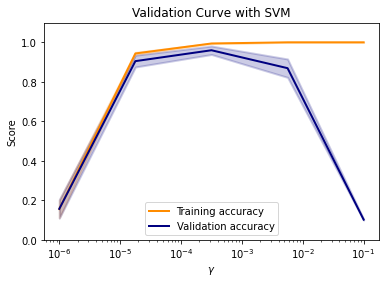

In [34]:
plt.title("Validation Curve with SVM")
plt.xlabel(r"$\gamma$")
plt.ylabel("Score")
plt.ylim(0.0, 1.1)
lw = 2
plt.semilogx(param_range, train_scores_mean, label="Training accuracy",
             color="darkorange", lw=lw)
plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2,
                 color="darkorange", lw=lw)
plt.semilogx(param_range, test_scores_mean, label="Validation accuracy",
             color="navy", lw=lw)
plt.fill_between(param_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.2,
                 color="navy", lw=lw)
plt.legend(loc="best")

This shows that the SVM:
* Underfits for small values of $\gamma < 10^{-5}$
* Overfits for large values of $\gamma > 10^{-3}$ and the training and validation curves diverge.

Medium values of $\gamma$ are just right.

<left><img width=25% src="img/cornell_tech2.svg"></left>

# Part 4: Distribution Mismatch

So far, we assumed that the distributions across different datasets are relatively similar.

When that is not the case, we may run into errors.

# Review: Datasets for Model Development

When developing machine learning models, it is customary to work with three datasets:
* __Training set__: Data on which we train the models.
* __Development set__ (validation or hold-out set): Data used for tuning models.
* __Test set__: Data for evaluating the final performance of our model.

# Review: Choosing Dev and Test Sets

The development and test sets should be from the data distribution we will see in production.

* This is because we want to be optimizing performance in deployment (e.g., classification accuracy on dog images).
* The training data could potentially be from a different distribution (e.g., include other types of animal images).

# Distribution Mismatch

We talk about distribution mismatch when the previously stated conditions don't hold, i.e. we have the following:
1. Our dev and test sets are no longer representative.
2. Our training set is too different from the dev set.

# Considerations For The Training Set

When adding more data to the training set,
1. The new data needs to be useful, e.g., images of animals (but probably not cars!) for a cats classifier.
2. The model needs to be expressive to be accurate on all types of input data.

# The Training Dev Set

In order to diagnose mismatch problems between the training and dev sets, we may create a new dataset.

The __training dev set__ is a random subset of the training set used as a second validation set.

# Diagnosing Bias and Variance

We may use this new dataset to diagnose distribution mismatch. Suppose dev set error is high.
* If the training error is low, but training dev and standard dev errors are high, we are overfitting.
* If the training and training dev errors are low, but dev error are high, we have distribution mismatch.

As an example, suppose are building a cat image classifier.
* The training set consists of cats and other animals.
* The traning dev set also containts cats and other animals.
* The dev and test sets only contain cats.

Consider the following example:
* Our training set error is 2%.
* Our training dev set error is 6%.
* Our dev set error is 6%.

This is a typical example of __high variance__ (overfitting).

Next, consider another example:
* Our training set error is 10%.
* Our training dev set error is 11%.
* Our dev set error is 12%.
* Human error is 1%.

This looks like an example of __high avoidable bias__ (underfitting).

Finally, suppose you see the following:
* Our training set error is 4%.
* Our training dev set error is 5%.
* Our dev set error is 13%.

This is a model that is generalizing to the training dev set, but not the standard dev set. Distribution mismatch is a problem.

# Quantifying Distribution Mismatch

We may quantify this issue more precisely using the following decomposition.

\begin{align*}
\text{dev error} & = 
(\underbrace{\text{dev error} - \text{dev train error}}_\text{distribution mismatch}) \\
& + (\underbrace{\text{dev train error} - \text{train error}}_\text{variance})
+ (\underbrace{\text{train error} - \text{opt error}}_\text{avoidable bias}) \\
& + \underbrace{\text{opt error}}_\text{unavoidable bias}
\end{align*}

# Beyond the Training Set

We may also apply this analysis to the dev and test sets to determine if they're stale.
1. First, collect additional real-world data.
2. If the model generalizes well the current dev and test sets but not the real-world data, the current data is stale!

# Addressing Data Mismatch

Correcting data mismatch requires:
1. Understanding the properties of the data that cause the mismatch.
2. Removing mismatching data and adding data that matches better.

The best way to understand data mismatch is using error analysis.